___
# __Deep Neural Network from scratch__
### _Author: Aki Taniguchi_
### _Original date: 09/01/2020_
### _Last update: 19/02/2020_
___

## __I. Setting up the environment__
___
### _I.A. Loading libraries_
First of all, we start by importing relevant libraries needed for the entire code.  
We will also set up our hypothetical hyper-parameters to double check at each step whether the function is working as intended.

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# Note that keras is only used to load the base dataset called MNIST

Using TensorFlow backend.


### _I.B. Data processing_
We will now load and process the MNIST data contained in keras datasets to have a concrete example on which we can test our neural network.

In [2]:
def load_dataset(first, second):
    # Load the base dataset using Keras MNIST Dataset, on which we only take 0 and 1 class as output values
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    class_0 = (y_train == first)
    class_0 = class_0.tolist()
    class_0 = [i for i, x in enumerate(class_0) if x]
    class_1 = (y_train == second)
    class_1 = class_1.tolist()
    class_1 = [i for i, x in enumerate(class_1) if x]

    index_key = class_0 + class_1

    X = x_train[index_key]
    Y = y_train[index_key]

    del (x_train, x_test, y_train, y_test)

    # We now have a binary outcome, between class_0 and class_1. Let's shuffle it a little so that the exercise is more interesting
    assert len(X) == len(Y)
    index_key = list(np.random.permutation(range(len(X))))
    X = X[index_key]
    Y = Y[index_key]


    # Data Processing

    # X has a shape of (n_x, m), n_x features and m observations
    # We transform the 28x28 pixel matrix into a 28^2 vector
    m = X.shape[0]
    n_x = X.shape[1] * X.shape[2]
    X = X.reshape(m, -1).T
    # This transforms (m, n_x1, n_x2) to (n_x1 * n_x2, m)

    # We also explicitly need to set Y column to be 1 ("?" by default in MNIST dataset)
    Y = Y.reshape(1, Y.shape[0])

    # Given the outcome is a categorical, we need a one-hot encoding of Y
    Y = np.where(Y == first, 0, 1)

    # Normalize X for quicker training
    X.astype("float64")
    X = X/255

    return X, Y

In [3]:
# Load the dataset and get X, Y
first = 4; second = 5
X, Y = load_dataset(first, second)

# Now initializing the A matrix, used in the Deep Neural Network
A = {}
A["0"] = X

# Making sure that we have same number of observations for X (or A0) and Y
assert Y.shape[1] == A["0"].shape[1]

# Show number of features and observations
print("Number of observations: {0}, Number of features: {1}".format(X.shape[1], X.shape[0]))
print("Number of outcome: {0}".format(Y.shape[1]))
print("X shape:", X.shape)
print("Y shape:", Y.shape)

Number of observations: 11263, Number of features: 784
Number of outcome: 11263
X shape: (784, 11263)
Y shape: (1, 11263)


[0]


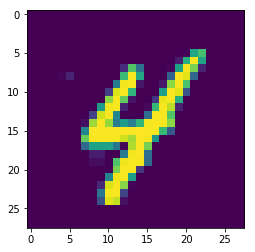

In [4]:
# Let us see what the pictures look like. The index can be changed up to m
ind = 10000
print(Y[:, ind])
plt.imshow(A["0"][:, ind].reshape(28,28))

### _I.C. Default Hyperparameter tuning_
Now that we have our dataset, we will set up the default Hyperparameter to use in order to test our algorithm.

In [5]:
# Setting up the hyper-parameters of the Deep Neural Network

# Number of Layer and Number of Neuron in each layer
# Input layer not included, last number should be number of Neuron for the output layer
nb_layer = 3
neuron_quantity = [4, 3, 1]
assert len(neuron_quantity) == nb_layer

# Define Activation function (needs to be same length as neuron Quantity)
# Note that the first term of the list should be "none", it corresponds to the input layer (no activation function)
activations = ["none", "relu", "relu", "sigmoid"]
assert len(activations) == nb_layer + 1

## II. Initialize parameters
___
We need to initialize the model parameters by assigning the following:
- for the weights (W), random numbers which have (n_l, n_l-1) dimension. They can't be assigned 0 due to Neural Network being unable to "break symmetry". However, we want them to be close to 0, so that the gradient descent works more efficiently (steeper curve around 0 for each activation function). 
- for biases (b), zero values which have (n_l, 1) dimension.


Note that the weight initialization follows the "He et al." rule, e.g.:
$$W^{[l]} = \mathcal{N}(0, 1) * \sqrt{\frac{2}{n^{[l-1]}}}$$
With:
$$dimW^{[l]} = (n^{[l]}, n^{[l-1]})$$
$$dimb^{[l]} = (n^{[l]}, 1)$$

In [6]:
def initialize_parameters(nb_layer, neuron_quantity, A):

    W = {}; b = {}; nb_neuron = {}
    L = nb_layer

    # Define number of Neuron, based on input so that we can set up the dimension of each parameter
    # The first dimension of the number of Neuron is the number of features (X), which corresponds to A["0"].
    nb_neuron["0"] = A["0"].shape[0]
    for l in range(1, nb_layer+1):
        nb_neuron[str(l)] = neuron_quantity[l-1]

    # Initializing parameters as defined above
    for l in range(1, L+1):
        W[str(l)] = np.random.randn(nb_neuron[str(l)], nb_neuron[str(l-1)]) * np.sqrt(2/nb_neuron[str(l-1)])
        b[str(l)] = np.zeros((nb_neuron[str(l)], 1))

    return W, b

In [7]:
# Double check if the function works well (both value and dimension) (W, b)
W, b = initialize_parameters(nb_layer, neuron_quantity, A)

print("W", W)
print("b", b)
for i in range(1, nb_layer+1):
    print("W[", str(i),"] shape:", W[str(i)].shape)
    print("b[", str(i),"] shape:", b[str(i)].shape)

W {'1': array([[ 0.06813496, -0.113581  , -0.04591331, ..., -0.01487198,
        -0.03150831, -0.03699605],
       [ 0.03422459, -0.0255665 ,  0.02833055, ...,  0.08516856,
         0.05082876,  0.06640435],
       [-0.00592826, -0.12947432,  0.03061235, ..., -0.01852709,
         0.00952344,  0.0409316 ],
       [ 0.1490021 ,  0.02636839,  0.02679676, ...,  0.04588083,
         0.08142183, -0.01054668]]), '2': array([[ 0.34007292,  0.0031619 , -1.73896654, -0.37924462],
       [ 0.3493665 , -0.24276346, -0.18874007, -1.09973402],
       [-1.12241603,  0.42644593,  0.22238428, -0.92671816]]), '3': array([[ 0.25213325, -1.16833534, -0.53193087]])}
b {'1': array([[0.],
       [0.],
       [0.],
       [0.]]), '2': array([[0.],
       [0.],
       [0.]]), '3': array([[0.]])}
W[ 1 ] shape: (4, 784)
b[ 1 ] shape: (4, 1)
W[ 2 ] shape: (3, 4)
b[ 2 ] shape: (3, 1)
W[ 3 ] shape: (1, 3)
b[ 3 ] shape: (1, 1)


## III. Forward propagation
___
We first need to define how to compute the activation function.  
Once the activation function is defined, we are ready to compute the linear function Z and its respective activated output A.  
Reminder of the formulas:
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]} \tag{1} $$  
And each activation function as follows:  
$$Linear = Z^{[l]}$$
$$ReLU = max(0, Z^{[l]})$$
$$LeakyReLU = max(0.01*Z^{[l]}, Z^{[l]})$$
$$Sigmoid = \frac{1}{1 + e^{-Z^{[l]}}}$$
$$Tanh = \frac{e^{Z^{[l]}} - e^{-Z^{[l]}}}{e^{Z^{[l]}} + e^{-Z^{[l]}}} \tag{2} $$
Therefore, g(Z) is the forward propagation and returns $x^{[l]}_{i} = y^{[l-1]}_{i}$ which will be used in the following layer.  
Note the dimension of both Z and A needs to be (n_l, m).

In [8]:
# Defining the helper function to compute the activation (fx(Z))
# We only treat Linear / ReLU / LeakyReLU / Tanh / Sigmoid funcions
def activation_function(activation_name, Z):
    if activation_name == "linear":
        fx = Z
    elif activation_name == "relu":
        fx = np.maximum(0, Z)
    elif activation_name == "leakyRelu":
        fx = np.maximum(Z*0.01, Z)
    elif activation_name == "tanh":
        fx = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    elif activation_name == "sigmoid":
        fx = 1 / (1 + np.exp(-Z))
    else:
        fx = "No function associated with: " + activation_name + "!"

    return fx      

In [9]:
# Calculate the forward propagation for each layer (Z, A)
# A is the feature/result matrix
# Note that both A and Z will be used in the backward propagation computation, hence the need to store them into variables
def forward_propagation(nb_layer, W, b, A, fx):
    
    L = nb_layer; Z = {}

    for l in range(1, L+1):

        Z[str(l)] = np.dot(W[str(l)], A[str(l-1)]) + b[str(l)]
        A[str(l)] = activation_function(fx[l], Z[str(l)])
    
    return A, Z

In [10]:
# Check if Activation function is working correctly
nb_check = -1
for i in range(0, nb_layer+1):
    check = activation_function(activations[i], nb_check)
    print(i, ": ", check)

# Check if forward propagtion is working correctly (need to run previous check cell)
A, Z = forward_propagation(nb_layer, W, b, A, activations)

print("A", A)
print("Z", Z)
for i in range(1, nb_layer+1):
    print("A[", str(i),"] shape:", A[str(i)].shape)
    print("Z[", str(i),"] shape:", Z[str(i)].shape)

0 :  No function associated with: none!
1 :  0
2 :  0
3 :  0.2689414213699951
A {'0': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), '1': array([[0.        , 0.69443793, 0.42261643, ..., 0.38985218, 0.        ,
        0.1142054 ],
       [0.28540468, 0.16623878, 0.50482531, ..., 0.60537091, 0.43314895,
        0.        ],
       [0.34964024, 0.26435467, 0.        , ..., 0.01446675, 0.20761659,
        0.15279269],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]]), '2': array([[0.        , 0.        , 0.14531661, ..., 0.10933509, 0.        ,
        0.        ],
       [0.        , 0.15236233, 0.02509488, ..., 0.        , 0.        ,
        0.01106144],
       [0.19946416, 0.        , 0.        , ..., 0.        , 0.23088527,
        0.        ]]), 

## IV. Calculate Cost
___
In this piece of code, we are creating an image recognition engine. Therefore, we use a logistic regression based neural network output, which means the cost function is the maximum likelihood estimation.  

For m observations, we have:  
$$Cost = -\frac{1}{m} \sum \limits_{i=1}^{m} {(y_{i} \log \left(a^{[L]}_{i} \right) + (1-y_{i}) \log \left(1-a^{[L]}_{i} \right)) } \tag{3} $$

In [11]:
# Compute Cost (Average of Loss)
def compute_cost(AL, Y):

    m = Y.shape[1]
    cost = -(1/m) * np.sum((Y * np.log(AL + 1e-8)) + (1-Y) * np.log(1 - AL + 1e-8))
    
    return cost

In [12]:
# Check if the cost function works
cost = compute_cost(A[str(nb_layer)], Y)
print(cost)

0.6920750301056589


## V. Backward Propagation
___
Now that we have the output as well as the cost function computed thanks to the forward propagation, we need to go backward to update the parameters.  

The best set of parameters which minimizes the cost function are the set of points where the first derivative is equal to 0. Thankfully, the cost function is convex, therefore the local minimum is a global minimum.  

However, the best set cannot be found as there is no closed-form equation to solve. The most efficient way is to use gradient descent, which is a method to find the minimum point iteratively, by substracting its slope (at the point of the moment). Effectively, if the slope is positive, this mean the minimum is "on the left", and the new parameter is small (x - s < x, with s > 0). Conversely, if we find out the slope is negative, the minimum is "on the right", so we get a bigger new parameter (x - s > x, given s < 0). Thus, substracting the slope at a given rate pushes to the right direction in finding the local minimum.  

We therefore understand that we need to compute the slope e.g. derivative on each point. To get the parameter derivative (dW, db), we will proceed using the chain rule (derivee de fonction composee). Let us start with dA and dZ, the derivative of the forward propagtion. Formulas are given as (in the order of backwardation):
$$dA^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} = \frac{-Y}{A^{[L]}} + \frac{(1-Y)}{(1-A^{[L]})} \tag{4}$$
$$dZ^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} = dA^{[L]} * g'(Z^{[L]}) \tag{5}$$
Now remind that, as per equation (1):
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
It follows that:
$$dA^{[L-1]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial A^{[L-1]}} = W'^{[L]} \times dZ^{[L]}$$
Which can be generalized as:
$$dA^{[l-1]} = W'^{[l]} \times dZ^{[l]} \tag{6}$$
And finally:
$$dZ^{[L-1]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial A^{[L-1]}} \frac{\partial A^{[L-1]}}{\partial Z^{[L-1]}} = W'^{[l]} \times dZ^{[l]} * g'(Z^{[L-1]})$$
Or more generally:
$$dZ^{[l-1]} = W'^{[l]} \times dZ^{[l]} * g'(Z^{[l-1]}) \tag{7}$$
In order to compute the backward propagation, we will therefore only use (4), (5) and (7).

<br>

Note on each activation function first order derivation (e.g. g'(Z)):
$$Linear = W^{[l]}$$
$$
ReLU =\left\{
    \begin{array}{ll}
        0 & \mbox{if} & Z < 0 \\
        1 & \mbox{if} & Z \geq 0 \\
    \end{array}
\right.
$$
$$
LeakyReLU = \left\{
    \begin{array}{ll}
        0.01 & \mbox{if} & Z < 0 \\
        1 & \mbox{if} & Z \geq 0 \\
    \end{array}
\right.
$$
$$Sigmoid = sigmoid(Z)(1 - sigmoid(Z)) $$
$$Tanh = 1 - tanh(Z)^{2} $$  

We have the back propagation implemented, we now need to calculate the gradient for each parameter W and b. From (1), (5) and (7) we have:
$$dZ^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} = dA^{[L]} * g'(Z^{[L]})$$
$$dZ^{[l-1]} = W'^{[l]} \times dZ^{[l]} * g'(Z^{[l-1]})$$
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
It follows that:
$$dW^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial W^{[L]}}= dZ^{[L]} \times A'^{[L-1]}$$  
Note that here again, we have $dW^{[L]} = A'^{[L-1]} \times dZ^{[L]} $ for observations set in rows.  

$$db^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial b^{[L]}}= dZ^{[L]}$$
For m observations, the gradient of one layer is simply the average of the gradient of that layer for all observations:
$$dW^{[l]} = \frac{1}{m} dZ^{[l]} \times A'^{[l-1]} \tag{8}$$  
$$db^{[l]} = \frac{1}{m} \sum \limits_{i=1}^{m} {dZ^{[l]}} \tag{9}$$

In [13]:
# Defining the helper function to compute the backward-activation (dfx/dZ)
# We only treat Linear / ReLU / LeakyReLU / Tanh / Sigmoid funcions
def backward_activation_function(activation_name, Z):
    if activation_name == "linear":
        dF = 1
    elif activation_name == "relu":
        dF = np.where(Z < 0, 0, 1)
    elif activation_name == "leakyRelu":
        dF = np.where(Z < 0, 0.01, 1)
    elif activation_name == "tanh":
        dF = 1 - np.power(activation_function(activation_name, Z), 2)
    elif activation_name == "sigmoid":
        dF = activation_function(activation_name, Z) * (1 - activation_function(activation_name, Z))
    else:
        dF = "No function associated with: " + activation_name + "!"

    return dF     

In [47]:
# Get the backward propagtion (dZ)
def backward_propagation(nb_layer, Y, A, Z, W, activations):
    
    L = nb_layer; dZ = {}

    # We need to compute the derivative of the last layer separately, as it is a non-generic formula
    # 1e-8 is added for numeric stability
    dAL = -Y / (A[str(L)] + 1e-8) + (1-Y) / ((1-A[str(L)]) + 1e-8)
    dZ[str(L)] = dAL * backward_activation_function(activations[L], Z[str(L)])

    # We can now compute the generalized backward propagation
    for l in range(L-1, 0, -1):
        dZ[str(l)] = np.dot(W[str(l+1)].T, dZ[str(l+1)]) * backward_activation_function(activations[l], Z[str(l)])

    return dZ

In [48]:
# Check if Backward Activation function is working correctly
nb_check = -1
for i in range(0, nb_layer+1):
    check = backward_activation_function(activations[i], nb_check)
    print(i, ": ", check)

# Check if forward propagtion is working correctly (need to run previous check cells)
dZ = backward_propagation(nb_layer, Y, A, Z, W, activations)
print("dZ", dZ)
for i in range(1, nb_layer+1):
    print("dZ[", str(i),"] shape:", dZ[str(i)].shape)

0 :  No function associated with: none!
1 :  0
2 :  0
3 :  0.19661193324148185
dZ {'3': array([[ 0.55449715,  0.57131959, -0.5038222 , ..., -0.51376852,
         0.55629176, -0.44878995]]), '2': array([[ 0.27206473,  0.28031868, -0.247201  , ..., -0.25208117,
         0.27294526, -0.22019936],
       [ 0.38062008,  0.39216741, -0.34583558, ..., -0.35266297,
         0.38185194, -0.30806013],
       [-0.2688375 , -0.27699354,  0.2442687 , ...,  0.24909098,
        -0.        ,  0.21758735]]), '1': array([[ 0.39512353,  0.40711086, -0.35901358, ..., -0.        ,
         0.26476995, -0.3197987 ],
       [-0.06306955, -0.06498297,  0.05730569, ...,  0.058437  ,
         0.37830764,  0.05104622],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
         0.        , -0.        ],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
         0.        , -0.        ]])}
dZ[ 1 ] shape: (4, 11263)
dZ[ 2 ] shape: (3, 11263)
dZ[ 3 ] shape: (1, 11263)


In [16]:
# Get the gradients for all layers (dW, db)
def calculate_gradient(nb_layer, dZ, A):

    m = A["0"].shape[1]
    L = nb_layer; dW = {}; db = {}

    for l in range(L, 0, -1):
        dW[str(l)] = 1/m * np.dot(dZ[str(l)], A[str(l-1)].T)
        db[str(l)] = 1/m * np.sum(dZ[str(l)], axis=1, keepdims=True)

    return dW, db

In [17]:
# Check if gradient is calculated correctly
dW, db = calculate_gradient(nb_layer, dZ, A)
print("dW", dW)
print("db", db)
for i in range(1, nb_layer+1):
    print("dW[", str(i),"] shape:", dW[str(i)].shape)
    print("db[", str(i),"] shape:", db[str(i)].shape)

dW {'3': array([[ 0.00183239,  0.0016018 , -0.001623  ]]), '2': array([[ 2.06371693e-03,  3.09932501e-03,  5.41020953e-05,
         4.10095491e-04],
       [-1.60842820e-02, -6.35139981e-03, -9.33828674e-03,
        -4.03250788e-04],
       [-7.16101438e-04, -3.22650653e-03,  7.47216222e-03,
         2.44085731e-04]]), '1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}
db {'3': array([[0.00857325]]), '2': array([[-0.00263545],
       [-0.00917122],
       [ 0.02211661]]), '1': array([[-0.00077648],
       [ 0.00793888],
       [ 0.00520318],
       [ 0.00152182]])}
dW[ 1 ] shape: (4, 784)
db[ 1 ] shape: (4, 1)
dW[ 2 ] shape: (3, 4)
db[ 2 ] shape: (3, 1)
dW[ 3 ] shape: (1, 3)
db[ 3 ] shape: (1, 1)


## VII. Update parameters
___
Thanks to the backward propagation, we now have been able to calculate the gradients. The only thing left is to update the parameters to approach the local minimum. The update is given as follows:
$$W^{[l]} = W^{[l]} - \alpha \times dW^{[l]} \tag{10}$$
$$b^{[l]} = b^{[l]} - \alpha \times db^{[l]} \tag{11}$$

In [18]:
# Get the updated parameters (W, b)
def update_parameters(nb_layer, W, b, dW, db, learning_rate):

    L = nb_layer

    for l in range(1, L+1):
        W[str(l)] = W[str(l)] - learning_rate * dW[str(l)]
        b[str(l)] = b[str(l)] - learning_rate * db[str(l)]
    
    return W, b

In [19]:
# Check if parameters are correctly updated
W, b = update_parameters(nb_layer, W, b, dW, db, learning_rate=0.01)
print("W:", W)
print("b:", b)

W: {'1': array([[ 0.06813496, -0.113581  , -0.04591331, ..., -0.01487198,
        -0.03150831, -0.03699605],
       [ 0.03422459, -0.0255665 ,  0.02833055, ...,  0.08516856,
         0.05082876,  0.06640435],
       [-0.00592826, -0.12947432,  0.03061235, ..., -0.01852709,
         0.00952344,  0.0409316 ],
       [ 0.1490021 ,  0.02636839,  0.02679676, ...,  0.04588083,
         0.08142183, -0.01054668]]), '2': array([[ 0.34005228,  0.00313091, -1.73896708, -0.37924872],
       [ 0.34952734, -0.24269995, -0.18864669, -1.09972999],
       [-1.12240887,  0.42647819,  0.22230955, -0.9267206 ]]), '3': array([[ 0.25211493, -1.16835136, -0.53191464]])}
b: {'1': array([[ 7.76477185e-06],
       [-7.93888491e-05],
       [-5.20318158e-05],
       [-1.52181543e-05]]), '2': array([[ 2.63545083e-05],
       [ 9.17121690e-05],
       [-2.21166102e-04]]), '3': array([[-8.57325034e-05]])}


## VII. Create the Deep Neural Network
___
Obviously, the gradient descent needs to be iterated several time to get the best parameter set which minimize the cost function.  
Therefore, we put all the above defined function into one single training function, which returns the optimum parameter set to be used in the following prediction function.  

For convenience, we will make the function displays the Cost/#Iteration plot for Cross-validation sake.

In [20]:
def deep_neural_network(nb_layer, neuron_quantity, activations, X, Y, learning_rate, epoch):

    # Make sure the number of Layer matches the length of the #Neuron vector
    assert len(neuron_quantity) == nb_layer

    # Initialize the A matrix, implementing A["0"] as the feature matrix
    A = {}
    A["0"] = X

    # Make sure there is as many observation (m) in X and Y (both dimension (1,m))
    assert Y.shape[1] == A["0"].shape[1]

    # Make sure there is enough activation function as number of Layer
    assert len(activations) == nb_layer + 1

    # Initialize all parameters
    L = nb_layer
    n = neuron_quantity
    costs = []
    W, b = initialize_parameters(L, n, A)

    # Process the iteration of FwdProp >> BwdProp >> UpdateParam >> FwdProp...
    for _ in range(epoch):
        A, Z = forward_propagation(L, W, b, A, activations)
        cost = compute_cost(A[str(L)], Y)
        costs.append(cost)
        dZ = backward_propagation(L, Y, A, Z, W, activations)
        dW, db = calculate_gradient(L, dZ, A)
        W, b = update_parameters(L, W, b, dW, db, learning_rate)

    # Display the Cost/#Iteration plot
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("# epoch")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return W, b

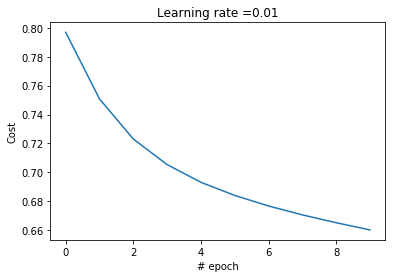

In [22]:
# Check if the deep neural network is working as intended, and plot the Cross-validation graph
weight, bias = deep_neural_network(nb_layer, neuron_quantity, activations, X, Y, learning_rate=0.01, epoch=10)

## IX. Create the prediction and accuracy function
___
The last and final step is to define the prediction function, which takes as input the parameters obtained thanks to the deep_neural_network function.  
Note that we do need to propagate forward only, as the set of parameters are already optimized. As such, the expected result is the optimal result.  

Finally, we also create the accuracy function to assess the accuracy of the model. It should be a different function than the cost function, which doesn't necessarily return a number between \[0, 1] (as the goal was to minimize it, it can go up to -$\infty$).

In [23]:
# Predict using W, b of the previous trained model
def predict(X, W, b, nb_layer, activations):

    A = {}
    A["0"] = X

    # We only need one forward propagation
    # We must include Z so that the forward propagation function doesn't return a tuple
    # However, Z is replaced with "_" as it will be unused
    A, _ = forward_propagation(nb_layer, W, b, A, activations)
    Yhat = np.where(A[str(nb_layer)] <= 0.5, 0, 1)

    return Yhat

In [24]:
# The Accuracy function
def model_accuracy(Yhat, Y):
    # Simply compare the predicted result vs real result
    # If it is the same, 1, if not 0. We then take the average
    error = np.where(Yhat == Y, 1, 0)    
    accuracy = np.mean(error)

    return accuracy

In [25]:
# Check if the prediction function works well
result = predict(X, weight, bias, nb_layer, activations)
accuracy = model_accuracy(result, Y)

# Tuning back the results from one-hot encoding to categorical values
# This will allow us to have a better comparison when comparing with the picture
Y = np.where(Y == 0, first, second)
result = np.where(result == 0, first, second)

print("Accuracy of the model: {0:.2f}%".format(accuracy*100))

Accuracy of the model: 53.17%


Result was: [4]
Prediction was: [4]


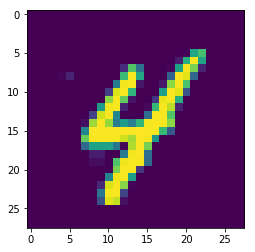

In [26]:
# Checking if the Neural Network learned properly with images
ind = 10000
print("Result was: {0}".format(Y[:, ind]))
print("Prediction was: {0}".format(result[:, ind]))
plt.imshow(A["0"][:, ind].reshape(28,28))

In [27]:
# Checking where we are wrong
list_error = [i for i, x in enumerate(Y.flatten() != result.flatten()) if x]
error_rate = len(list_error) / len(Y.flatten()) * 100
print("The model predicted wrong {0} times, or {1:.2f}% of the time".format(len(list_error), error_rate))

The model predicted wrong 5274 times, or 46.83% of the time


## X. Optimization
___
### X.A. Regularization
#### X.A.1. L2 Regularization
Same concept in Statistics.
Penalizes complex model. add lambda/2m * Norm Param (scalar) to the cost function. As we add a scalar to the cost function, it shifts up the function, which in turn shifts up the optimal point.

A complex model is a model with a lot of layer, with big weights. This often leads to overfitting (e.g. big weights). Indeed, the bigger the weight, the bigger Norm Param.

In [ ]:
def L2_regularization(nb_layer, W,  regulator=0.0):

    L = nb_layer 
    l2reg = 0
    m = W["1"].shape[0]
    
    for l in range(1, nb_layer-1):
        l2reg += np.sum(np.square(W[str(l)]))
    
    l2reg *= (1/m)*(regulator/2) 

    return l2reg

In [ ]:
def back_L2_regularization():
    

In [ ]:
# Load initial data in order to start the checking
X, Y = load_dataset()
A = {}
A["0"] = X
W, b = initialize_parameters(nb_layer, neuron_quantity, A)
A, Z = forward_propagation(nb_layer, W, b, A, activations)
dZ = backward_propagation(nb_layer, Y, A, Z, W, activations)
dW, db = calculate_gradient(nb_layer, dZ, A)
W, b = update_parameters(nb_layer, W, b, dW, db, learning_rate=0.01)

l2reg = L2_regularization(4, W, regulator=1)
l2reg

#### X.A.2. Drop-out Regularization
Randomly drop-out neurons.

In [ ]:
def fwd_drop_out():
    

In [ ]:
def back_drop_out():
    

### X.B. Batching
The cost function that we implement in Deep Learning might not be strictly convex. In this case, there might be few (or many) local minima (all 2nd partial derivatives are convex at this point) or saddle points (some 2nd degree derivatives are convex, the others concave), which don't necessarily equate to the global minimum. If the gradient descent gets stuck in those points, it will end up never finding the global minimum (e.g. not converging, hence not getting the best parameters set).  

One way to avoid this issue is to implement an element of randomness in the descent. Indeed, if the descent is stochastic (totally random), it can get out of those wrong minimum points and continue its way through the global optima. However, there are also downside to it as well: as each calculation is done separately, we lose all the benefit of the vectorization, hence reducing the computational power, reducing down the execution. It therefore requires a lot of parallelization to speed up the process. In addition, the GD never converges toward the optimal point. Indeed, as it jumps around constantly, it keeps rotating around the minimum point to find.

The middle ground is the mini-batch Gradient Descent, which breaks down the batch GD into multiple mini-batch of size i. Not only does it help to escape saddle point (however with a lower probability than SGD), it does converges toward the optima (although slower compared to batch GD). Moreover, it still keeps the benefit of vectorization, while having sufficient batch number to fully benefit from few GPU parallelization.

Note that in any case as i < m, training the model on one computer (e.g. without parallelization) slows down the computation (or to be precise, it improves computation for one iteration, but reduces the speed through one epoch).  

One final note is that for very large data sets, it is often unrealistic to use batch GD as it is impossible to read all data and store them in the GPU in one go. The most common method is therefore the mini-batch GD, which has the best of each other technique.

- i = m, batch GD  
- i = i, mini-batch GD  
- i = 1, stochastic GD (a.k.a SGD)  

In [28]:
def create_batch(X, Y, batch_size):

    # Create random partition index. nbBatch number of list of index list
    m = X.shape[1]

    # Handling the case where there is a higher batch size than actual observations
    if m < batch_size: raise ValueError("Batch size higher than number of observation")

    # Shuffling the dataset (X and Y shuffled the same way to keep accordance). By doing this, each epoch should have a different mini_batch
    index_list = list(np.random.permutation(m))
    X = X[:, index_list]
    Y = Y[:, index_list]


    # Create a list containing array of mini_batch
    nb_batch, rest = divmod(m, batch_size)
    X_batch = []; Y_batch = []

    for i in range(nb_batch):
        X_mini_batch = X[:, batch_size*i:batch_size*(i+1)]
        X_batch.append(X_mini_batch)
        Y_mini_batch = Y[:, batch_size*i:batch_size*(i+1)]
        Y_batch.append(Y_mini_batch)
    
    if rest != 0:
        X_mini_batch = X[:, batch_size*nb_batch:m]
        X_batch.append(X_mini_batch)
        Y_mini_batch = Y[:, batch_size*nb_batch:m]
        Y_batch.append(Y_mini_batch)
    
    return X_batch, Y_batch

In [29]:
batch_size = 128
X_batch, Y_batch = create_batch(X, Y, batch_size)

test_sum = 0
for i in range(len(X_batch)):
    print("Batch #{0}, X_batch size is: {1}, and Y_batch size is: {2}". format(i, X_batch[i].shape, Y_batch[i].shape))
    test_sum += X_batch[i].shape[1]

nb_batch, last_batch_length = divmod(X.shape[1], batch_size)
print("\nThere should be: {0} batches of sizes {1}, and last batch size should be: {2}".format(nb_batch, batch_size, last_batch_length))
print("\nTotal number of observation: {0}, Batch sum observation: {1}".format(X.shape[1], test_sum))

Batch #0, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #1, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #2, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #3, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #4, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #5, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #6, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #7, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #8, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #9, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #10, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #11, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #12, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #13, X_batch size is: (784, 128), and Y_batch size is: (1, 128)
Batch #14, X_batch size is: (7

### X.C. Momentum
As we have seen, it is more optimal to use mini-batches (even SGD) as it improves the algorithm probability to escape saddle points. However, we have also seen that implementing batching-split does slower the speed to convergence. One technique to speed-up the velocity toward convergence of the optimal point is momentum.  
We replace gradients by their exponentially weighted average. By doing so, the oscilliation of the cost output is smoothed out, and therefore converges more rapidly toward the optimum point. To illustrate in 2D, it reduces jumps on the y axis, while increasing the moving speed along the x axis. Due to this nature, it is also called velocity, and it can be expressed as follows:  
$$
\left\{
    \begin{array}{ll}
        Vw^{[l]}_{\{b\}} = \beta . Vw^{[l]}_{\{b-1\}} - (1 - \beta) . dW^{[l]}_{\{b\}} \\
        W^{[l]}_{\{b\}} = W^{[l]}_{\{b\}} - \alpha . Vw^{[l]}_{\{b\}}
    \end{array}
\right.
$$
$$
\left\{
    \begin{array}{ll}
        Vb^{[l]}_{\{b\}} = \beta . Vb^{[l]}_{\{b-1\}} - \alpha . db^{[l]}_{\{b\}} \\
        b^{[l]}_{\{b\}} = b^{[l]}_{\{b\}} + Vb^{[l]}_{\{b\}}
    \end{array}
\right.
$$

Note that the average is done through __iteration and epoch__, and __NOT between layers__. Hence, the notation {b} has been added, indicating the iteration #b.

In [30]:
# The velocity of the gradient descent needs to be updated. Its dimension needs to be the same as the parameters' respective dimension
def initialize_momentum(nb_layer, W, b):
    
    Vw = {}; Vb = {}
    L = nb_layer
    
    for l in range(1, L+1):
        Vw[str(l)] = np.zeros((W[str(l)].shape[0], W[str(l)].shape[1]))
        Vb[str(l)] = np.zeros((b[str(l)].shape[0], b[str(l)].shape[1]))
    
    return Vw, Vb

In [31]:
# For each layer, we need to compute the velocity of the Gradient Descent, and then update the parameters using this velocity
# Note that the velocity is updated thanks to the main deep neural network code: the velocity is computed at each iteration, and this function will help updating the velocity each time we pass through the iteration (hence this function doesn't have an explicit {b} for loop, which is done at a higher level)
def momentum(nb_layer, W, b, dW, db, Vw, Vb, beta=0.9, learning_rate=0.01):

    L = nb_layer

    for l in range(1, L+1):
        # Velocity computation for each parameter dW and db
        Vw[str(l)] = beta * Vw[str(l)] + (1-beta) * dW[str(l)] 
        Vb[str(l)] = beta * Vb[str(l)] + (1-beta) * db[str(l)]

        # Parameter update
        W[str(l)] = W[str(l)] - learning_rate * Vw[str(l)]
        b[str(l)] = b[str(l)] - learning_rate * Vb[str(l)]

    return W, b

In [32]:
# Load initial data in order to start the checking
X, Y = load_dataset(first, second)
A = {}
A["0"] = X
W, b = initialize_parameters(nb_layer, neuron_quantity, A)
A, Z = forward_propagation(nb_layer, W, b, A, activations)
dZ = backward_propagation(nb_layer, Y, A, Z, W, activations)
dW, db = calculate_gradient(nb_layer, dZ, A)

# Check if the momentum algorithm works well
Vw, Vb = initialize_momentum(nb_layer, W, b)
print("__________Initialization__________")
print("Vw:",Vw)
print("Vb:", Vb)

W, b = momentum(nb_layer, W, b, dW, db, Vw, Vb, beta=0.9, learning_rate=0.01)
print("\n__________Momentum__________")
print("W:", W)
print("b:", b)

__________Initialization__________
Vw: {'1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), '2': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), '3': array([[0., 0., 0.]])}
Vb: {'1': array([[0.],
       [0.],
       [0.],
       [0.]]), '2': array([[0.],
       [0.],
       [0.]]), '3': array([[0.]])}

__________Momentum__________
W: {'1': array([[ 0.05821157, -0.00367306,  0.03461713, ...,  0.0109903 ,
        -0.07229559,  0.00013954],
       [-0.08768919, -0.05237541,  0.0355865 , ..., -0.00762304,
        -0.02702086,  0.08190365],
       [-0.00803435, -0.05144892,  0.06830822, ..., -0.01865488,
        -0.08616958,  0.00933903],
       [ 0.06362093, -0.0011629 ,  0.06601655, ...,  0.01335391,
        -0.05051108, -0.01259223]]), '2': array([[ 0.16200205, -0.26612449,  0.77926543,  0.49211561],
       [ 0.45518324, -0.48742423, -0.93724926,  0.2809

### X. Interlude - Exploding / Vanishing Gradients issue
When the cost function is extremely hyperbolic (e.g. very steep even close to the optimum point), the gradients around this extrema can become extremely large. In these instances, the network doesn't learn well, the descent jumps around the wall never converging due to the steepness of both side.  
Likewise, when the cost function minimum point is located in a plateau, the gradient becomes vanishingly small. Thus, the model stop learning as the parameter update becomes irrelevant.  
The above two cases are not problematic for shallow network: this issue can be easily dealth with adapting the learning rate (make it very small if gradients are too big, or make it very big as gradients are too small). However, this becomes more of an issue as we add more layer to the network. Indeed, due to the chain rule, the backpropagation update gradients geometrically. This is known as "Exploding / Vanishing" gradient problem.  

We have seen from equation (7), (8) and (9) that:  
$$
\left\{
    \begin{array}{ll}
        dZ^{[l]} = dZ^{[l+1]}W'^{[l+1]} * g'(Z^{[l]}) \\
        dW^{[l]} = \frac{1}{m} dZ^{[l]} * A'^{[l-1]} \\
        db^{[l]} = \frac{1}{m} \sum \limits_{i=1}^{m} {dZ^{[l]}}
    \end{array}
\right.
$$

On the first layer, we have (for one layer):  
$$
\left\{
    \begin{array}{ll}
        dW^{[1]} = \frac{1}{m} dZ^{[1]} * A'^{[0]} \\
        db^{[1]} = \frac{1}{m} \sum \limits_{i=1}^{m} {dZ^{[1]}}
    \end{array}
\right.
$$  

With: $dZ^{[1]} = dZ^{[2]}W'^{[2]} * g'(Z^{[1]})$
We rewrite the layer 1 paramter as follows:  
$$
\left\{
    \begin{array}{ll}
        dW^{[1]} = \frac{1}{m} dZ^{[2]}W'^{[2]} * g'(Z^{[1]}) * A'^{[0]} \\
        db^{[1]} = \frac{1}{m} \sum \limits_{i=1}^{m} {dZ^{[2]}W'^{[2]} * g'(Z^{[1]})}
    \end{array}
\right.
$$  

Assuming there is another layer, using $dZ^{[2]} = dZ^{[3]}W'^{[3]} * g'(Z^{[2]})$, we break it down further:  
$$
\left\{
    \begin{array}{ll}
        dW^{[1]} = \frac{1}{m} dZ^{[3]}W'^{[3]} * g'(Z^{[2]}) W'^{[2]} * g'(Z^{[1]}) * A'^{[0]} \\
        db^{[1]} = \frac{1}{m} \sum \limits_{i=1}^{m} {dZ^{[3]}W'^{[3]} * g'(Z^{[2]}) W'^{[2]} * g'(Z^{[1]})}
    \end{array}
\right.
$$

We can generalize this formula for an L-layer deep neural network:  
$$
\left\{
    \begin{array}{ll}
        dW^{[i]} = \frac{1}{m} dZ^{[L]} . A'^{[0]} \prod \limits_{l=i+1}^{L} {W'^{[l]}} \prod \limits_{l=i}^{L-1} {g'(Z^{[l]})} \\
        db^{[i]} = \frac{1}{m} \sum \limits_{j=1}^{m} ( {dZ^{[L]} \prod \limits_{l=i+1}^{L} {W'^{[l]}} \prod \limits_{l=i}^{L-1} {g'(Z^{[l]})} )}
    \end{array}
\right.
$$  

Therefore:
$$ \frac{\partial C}{\partial (W, b)} \propto \prod {g'(Z)} \prod {W} $$  

From these equations, it is therefore clear that each Gradients are proportional to the product of all derivative of activation function, and/or the product of all weight.  

As shown in the Appendix, the derivative of Sigmoid returns values between \[0, 0.25\]. Clearly, $g'(Z)^{l}$ will be very small, and therefore the parameter update will be almost neglible (tanh will be the same to a lesser extent, as its derivative will return \[0, 1\], with a very steep declined toward 0 very quickly).  
A partial solution to this issue is to use ReLU or LeakyReLU, as their derivative both returns 0 (or 0.01) or 1. However, ReLU weakness is that it can kill neurons where Z is negative (countered using LeakyReLU which derivative returns 0.01 instead of 0). Moreover, the ReLU family still suffers from the Vanishing Gradient issue in some cases where its weights are very small. 

Note that we are a lot less likely to have issues with exploding gradients with our usual activation functions, given their derivative's maximum value is 1.

### X. Interlude 2 - Adaptive Learning Rate and Keeping the sign of Gradients

__The example of Rprop (Resilient Backpropagation):__  
Due to the Vanishing Gradient issue, gradients alone cannot be fully trusted. A way to cope with is to get rid of the magnitude of the gradients and regularize the learning rate instead, while keeping the sign of the gradients so that we know the direction of the descent. This statement can be expressed as follows:
$$ W^{[l]} = W^{[l]} - f(\alpha) . sgn(dW^{[l]})$$
(Note that for simplicity, we have only expressed the equation for the weights W, but the same applies to the bias b).  
It can also be interpreted as:
$$ W^{[l]} = W^{[l]} - \frac{f(\alpha)} {\mid dW^{[l]} \mid} dW^{[l]}$$
With $f(\alpha)$ being a function applied to the learning rate $\alpha$ in order to gradually increase/decrease its value (to deal with the lack of magnitude).  
Basically, we compare the new gradients against the previous ones; if the signs are equal, this means we are moving in the right direction: we need to accelerate the pace by increasing the learning rate. On the other hand if signs are different, it means we have crossed the optimum point, and therefore we need to reduce the learning rate size so that we can converge. If the gradients are equal (the only times gradients are equal is when they are both equal to 0), then we have found the optimum point. This translates to the following function:
$$
f(\alpha)^{[l]}_{i} = \left\{
    \begin{array}{ll}
        min(f(\alpha)^{[l]}_{i-1} * \gamma_{1}, \lambda_{floor}) & \mbox{if} & dW^{[l]} * dW^{[l-1]} > 0 \\
        max(f(\alpha)^{[l]}_{i-1} * \gamma_{2}, \lambda_{cap}) & \mbox{if} & dW^{[l]} * dW^{[l-1]} < 0 \\
        f(\alpha)^{[l]}_{i-1} & \mbox{if} & dW^{[l]} = dW^{[l-1]} = 0
    \end{array}
\right.
$$
Note that $\{ \lambda_{cap}, \lambda_{floor}, \gamma_{1}, \gamma_{2}, f(\alpha)^{[l]}_{0} \}$ are all hyper-parameters which need to be set. It also makes sense that $\gamma_{1} > 1 > \gamma_{2}$, as $\gamma$ represents the decaying/boosting factor, and generally set to: $\gamma_{1} = 1.2$ and $\gamma_{2} = 0.5$.

### X.D. RMSProp (Root Mean Squared Backpropagation)
Note that however, it seems that Rprop doesn't work well with smaller batch size. While there is no clear demonstration of why it is doing so, an initial intuition is that it is similar to SGD, where gradients jumps around through batches and do not end up converging. Therefore, we would like to keep the idea of Rprop to cope with Vanishing Gradients (e.g. ignoring the magnitude of the gradients but use their sign for direction), while making sure the solution converges toward the optima.  
An idea is to introduce a Weighted Average of Gradients in Rprop so that the adaptive learning rate get updated smoothly across batches. As such, we can modify Rprop as follows:
$$ W^{[l]} = W^{[l]} - g(\alpha) . dW^{[l]}$$
Or:
$$ W^{[l]} = W^{[l]} - \frac{\alpha} {Ew} . dW^{[l]}$$
Where E is the equation which satisfies:  

- Take away dW magnitude to get rid of exploding/vanishing gradient issue  
- Keep dW sign for direction  
- Compute Average across batches (last value being more important)  

We get:
$$
\left \{
    \begin{array}{ll}
        Ew^{[l]}_{\{b\}} = \sqrt{\beta Ew^{[l]}_{\{b-1\}} + (1-\beta) dW^{[l]2}} \\
        Ew^{[l]}_{corr\{b\}} = \frac{Ew^{[l]}_{\{b\}}}{\sqrt {1-\beta^{t}}}
    \end{array}
\right.
$$

The RMSProp Parameter updates can be therefore expressed as:
$$ W^{[l]}_{\{b\}} = W^{[l]}_{\{b\}} - \frac{\alpha} {Ew^{[l]}_{corr\{b\}}} . dW^{[l]}_{\{b\}}$$

As such, we obtained a final equation which satisfied of all the requirements. Indeed:  
- Gradients (dW, db) magnitude is offset as we divide by itself (dW, db)
- Gradients sign is kept: the division $\frac{dW}{\sqrt {dW^{2}}}$ keeps the sign of dW
- The learning rate decay is averaged (exponentially weighted) throughout batches, smoothing out the stochastic property of Rprop adaptive learning rate
- We added a correction term $\frac {1} {1-\beta ^{l}}$ to boost the first terms of the exponential weighted average
As a consequence, parameters (W, b) should always have a consequent updated (no more Vanishing Gradient), going increasingly quickly in the right direction but also smoothed out to ensure convergence.

Note that this expression can be used for both parameters: Weights and Biases (bias hasn't been showed for convenience).  
Additionally, note that similarly to momentum, the average is done at the batch level, e.g. average of all batches dW for one epoch. 

In [33]:
# The learning rate decay needs to be updated. Its dimension needs to be the same as the parameters' respective dimension
def initialize_rmsprop(nb_layer, W, b):
    
    Ew = {}; Eb = {}
    L = nb_layer

    for l in range(1, L+1):
        Ew[str(l)] = np.zeros((W[str(l)].shape[0], W[str(l)].shape[1]))
        Eb[str(l)] = np.zeros((b[str(l)].shape[0], b[str(l)].shape[1]))
    
    return Ew, Eb

In [34]:
# For each layer, we need to compute the learning rate decay, and then update the parameters using this decay term
# Note that the decay is updated thanks to the main deep neural network code: the decay is computed at each iteration, and this function will help updating the decay each time we pass through the iteration (hence this function doesn't have an explicit {b} for loop, which is done at a higher level)
# This is actually shown in the correction, where num_batch represents the current batch number
# The correction term gradually converges toward 1 as we move further down the batch iteration
def rmsprop(nb_layer, W, b, dW, db, Ew, Eb, num_batch, beta=0.9, learning_rate=0.01):

    L = nb_layer

    # Initialization of corrected decay
    Ew_corrected = {}; Eb_corrected = {}

    # Calculation of the correction term, which changes in function of num_batch
    correction = 1 / (1-np.power(beta, num_batch))

    for l in range(1, L+1):
        # Decay computation for each parameter dW and db
        Ew[str(l)] = beta * Ew[str(l)] + (1-beta) * np.power(dW[str(l)], 2)
        Ew_corrected[str(l)] = Ew[str(l)] * correction
        Eb[str(l)] = beta * Eb[str(l)] + (1-beta) * np.power(db[str(l)], 2)
        Eb_corrected[str(l)] = Eb[str(l)] * correction

        # Parameter update
        W[str(l)] = W[str(l)] - learning_rate * dW[str(l)] / (np.sqrt(Ew_corrected[str(l)]) + 1e-8)
        b[str(l)] = b[str(l)] - learning_rate * db[str(l)] / (np.sqrt(Eb_corrected[str(l)]) + 1e-8)

    return W, b

In [35]:
# Load initial data in order to start the checking
X, Y = load_dataset(first, second)
A = {}
A["0"] = X
W, b = initialize_parameters(nb_layer, neuron_quantity, A)
A, Z = forward_propagation(nb_layer, W, b, A, activations)
dZ = backward_propagation(nb_layer, Y, A, Z, W, activations)
dW, db = calculate_gradient(nb_layer, dZ, A)

# Check if the RMSProp algorithm works well
Ew, Eb = initialize_rmsprop(nb_layer, W, b)
print("__________Initialization__________")
print("Ew:", Ew)
print("Eb:", Eb)


W, b = rmsprop(nb_layer, W, b, dW, db, Ew, Eb, num_batch = 2, beta=0.9, learning_rate=0.01)
print("\n__________RMSProp__________")
print("W:", W)
print("b:", b)

__________Initialization__________
Ew: {'1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), '2': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), '3': array([[0., 0., 0.]])}
Eb: {'1': array([[0.],
       [0.],
       [0.],
       [0.]]), '2': array([[0.],
       [0.],
       [0.]]), '3': array([[0.]])}

__________RMSProp__________
W: {'1': array([[ 0.02349062, -0.10811178,  0.08579347, ..., -0.11449562,
        -0.11595759, -0.0389706 ],
       [-0.01642357,  0.01341822, -0.03023321, ..., -0.04080576,
         0.01816905,  0.09743907],
       [-0.05834516,  0.01502767, -0.01386695, ...,  0.08911769,
         0.11230503, -0.00428868],
       [-0.02208291, -0.02162886,  0.01049999, ..., -0.04767598,
        -0.06724758, -0.03283456]]), '2': array([[-0.96040693,  0.05481514,  0.04136555,  1.16657762],
       [-0.41178824, -0.52205754, -0.10983955, -1.06213

### X.F. Adam (Adaptive Moment Estimation)
Although RMSProp deals with a lot of issues we have seen, it still struggles with saddle points and non-convex cost functions. As such, the current most used optimization methods combines Momentum (which prevents getting stuck with local minima) and RMSProp, and is called Adam.
This is mainly the same as RMSProp, with Gradients boosted by the momentum velocity. Therefore, we first compute the stochastic gradients with momentum:
$$ Vw^{[l]}_{\{b\}} = \beta_{1} . Vw^{[l]}_{\{b-1\}} - (1 - \beta_{1}) . dW^{[l]}_{\{b\}} $$

The velocity term can now be incorporated in the RMSProp equation:
$$ Ew^{[l]}_{\{b\}} = \sqrt{\beta_{2} Ew^{[l]}_{\{b-1\}} + (1-\beta_{2}) dW^{[l]2}_{\{b\}}} $$

Note that each term, the velocity and the learning rate decay take the form of an exponential weighted average. It is therefore imperative to correct the bias of the initial stage, therefore:
$$
\left \{
    \begin{array}{ll}
        \mbox{Velocity correction} = \frac{1}{1-\beta_{1}^{t}} \\
        \mbox{Decay correction} = \sqrt {\frac{1}{1-\beta_{2}^{t}}}
    \end{array}
\right.
$$

Adam parameter update equation can thus be expressed as:
$$
\left \{
    \begin{array}{ll}
        Vw^{[l]}_{\{b\}} = \beta_{1} . Vw^{[l]}_{\{b-1\}} - (1 - \beta_{1}) . dW^{[l]}_{\{b\}} \\
        Vw^{[l]}_{corr\{b\}} = \frac {Vw^{[l]}_{\{b\}}} {1-\beta_{1}^{t}} \\
        Ew^{[l]}_{\{b\}} = \sqrt{\beta_{2} Ew^{[l]}_{\{b-1\}} + (1-\beta_{2}) dW^{[l]2}_{\{b\}}} \\
        Ew^{[l]}_{corr\{b\}} = \sqrt{ \frac {Ew^{[l]}_{\{b\}}} {1-\beta_{2}^{t}} } \\
        W^{[l]}_{\{b\}} = W^{[l]}_{\{b\}} - \frac{\alpha} {Ew^{[l]}_{corr\{b\}}} * Vw^{[l]}_{corr\{b\}}
    \end{array}
\right.
$$

As stated above, this is currently the most commonly used optimization algorithm as it cope with all previously seen issues, and doesn't get stuck in saddle points, therefore has a relatively fast convergence toward the global minimum.

In [36]:
# Both the velocity and the learning rate decay needs to be updated. Its dimension needs to be the same as the parameters' respective dimension
def initialize_adam(nb_layer, W, b):

    L = nb_layer
    Vw, Vb = initialize_momentum(L, W, b)
    Ew, Eb = initialize_rmsprop(L, W, b)

    return Vw, Vb, Ew, Eb

In [37]:
# The implementation of Adam is basically just a combination of Mometum and RMSProp, with a bias correction added to the velocity term
# Note that similarly to RMSProp we have added 1e-8 for numerical stability
def adam(nb_layer, W, b, dW, db, Vw, Vb, Ew, Eb, num_batch, beta1=0.9, beta2=0.999, learning_rate=0.01):
    
    L = nb_layer

    # Initialization of corrected velocity and decay
    Vw_corrected = {}; Vb_corrected = {}
    Ew_corrected = {}; Eb_corrected = {}

    # Calculation of the correction term, which changes in function of num_batch
    velocity_correction = 1 / (1-np.power(beta1, num_batch))
    decay_correction = 1 / (1-np.power(beta2, num_batch))

    for l in range(1, L+1):
        # Velocity computation for each parameter dW and db
        Vw[str(l)] = beta1 * Vw[str(l)] + (1-beta1) * dW[str(l)] 
        Vw_corrected[str(l)] = Vw[str(l)] * velocity_correction
        Vb[str(l)] = beta1 * Vb[str(l)] + (1-beta1) * db[str(l)]
        Vb_corrected[str(l)] = Vb[str(l)] * velocity_correction

        # Decay computation for each parameter dW and db
        Ew[str(l)] = beta2 * Ew[str(l)] + (1-beta2) * np.power(dW[str(l)], 2)
        Ew_corrected[str(l)] = Ew[str(l)] * decay_correction
        Eb[str(l)] = beta2 * Eb[str(l)] + (1-beta2) * np.power(db[str(l)], 2)
        Eb_corrected[str(l)] = Eb[str(l)] * decay_correction

        # Parameter update
        W[str(l)] = W[str(l)] - learning_rate * Vw_corrected[str(l)] / (np.sqrt(Ew_corrected[str(l)]) + 1e-8)
        b[str(l)] = b[str(l)] - learning_rate * Vb_corrected[str(l)] / (np.sqrt(Eb_corrected[str(l)]) + 1e-8)

    return W, b

In [38]:
# Load initial data in order to start the checking
X, Y = load_dataset(first, second)
A = {}
A["0"] = X
W, b = initialize_parameters(nb_layer, neuron_quantity, A)
A, Z = forward_propagation(nb_layer, W, b, A, activations)
dZ = backward_propagation(nb_layer, Y, A, Z, W, activations)
dW, db = calculate_gradient(nb_layer, dZ, A)

# Check if the Adam algorithm works well
Vw, Vb, Ew, Eb = initialize_adam(nb_layer, W, b)
print("__________Initialization__________")
print("Vw:", Vw)
print("Vb:", Vb)
print("Ew:", Ew)
print("Eb:", Eb)

W, b = adam(nb_layer, W, b, dW, db, Vw, Vb, Ew, Eb, num_batch = 5, beta1=0.9, beta2=0.999, learning_rate=0.01)
print("\n__________Adam__________")
print("W:", W)
print("b:", b)

__________Initialization__________
Vw: {'1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), '2': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), '3': array([[0., 0., 0.]])}
Vb: {'1': array([[0.],
       [0.],
       [0.],
       [0.]]), '2': array([[0.],
       [0.],
       [0.]]), '3': array([[0.]])}
Ew: {'1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), '2': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), '3': array([[0., 0., 0.]])}
Eb: {'1': array([[0.],
       [0.],
       [0.],
       [0.]]), '2': array([[0.],
       [0.],
       [0.]]), '3': array([[0.]])}

__________Adam__________
W: {'1': array([[-0.03167304, -0.05339921, -0.03229469, ..., -0.02949307,
         0.0594611 , -0.03278001],
       [-0.07811963,  

### X.G. Batch Normalizaion
Simply normalizes each input.
$$ Z_{norm} = \frac{Z - \mu_{Z}}{\sigma_{Z}}$$

In [ ]:
def batch_norm():
    

Fully upgraded Multi-Layer Deep Neural Network, including Regularization, Optimization (Batching, Normalization, Gradient Optimization, Weight Initialization

In [39]:
def improved_deep_neural_network(nb_layer, neuron_quantity, activations, X, Y, epoch=10, batch_size=X.shape[0], optimization=None, learning_rate=0.01, momentum_beta=0.9, rms_beta=0.999, show_cost=False):

    # Make sure the number of Layer matches the length of the #Neuron vector
    assert len(neuron_quantity) == nb_layer

    # Make sure there is enough activation function as number of Layer
    assert len(activations) == nb_layer + 1

    # Initialize the A matrix, implementing A["0"] as the feature matrix
    A = {}
    A["0"] = X

    # Make sure there is as many observation (m) in X and Y (both dimension (m, 1))
    assert Y.shape[1] == A["0"].shape[1]

    # Initialize all parameters
    L = nb_layer
    n = neuron_quantity
    epoch_costs = []
    batch_costs = []
    W, b = initialize_parameters(L, n, A)

    if optimization == "momentum":
        Vw, Vb = initialize_momentum(L, W, b)
    elif optimization == "rmsprop":
        Ew, Eb = initialize_rmsprop(L, W, b)
    elif optimization == "adam":
        Vw, Vb, Ew, Eb = initialize_adam(L, W, b)


    # Run the Neural network per epoch
    for j in range(epoch):

        # Create batches for each epoch. This creates random batches different each time
        X_batch, Y_batch = create_batch(X, Y, batch_size)
        iteration = len(X_batch)

        # Note that we only need the cost for one epoch, not for all mini-batches
        # We will therefore need to take the average, hence the need to sum them up together
        # We need to reset the cost after each epoch
        total_cost = 0


        # Process the iteration of FwdProp >> BwdProp >> UpdateParam >> FwdProp... for each batch and for each epoch
        for i in range(iteration):
            
            # Initialize the A matrix, implementing A["0"] as the feature matrix
            A = {}
            A["0"] = X_batch[i]

            A, Z = forward_propagation(L, W, b, A, activations)

            # Summing up all costs for later averaging
            cost = compute_cost(A[str(L)], Y_batch[i])
            total_cost += cost

            dZ = backward_propagation(L, Y_batch[i], A, Z, W, activations)

            dW, db = calculate_gradient(L, dZ, A)

            
            if optimization == None:
                W, b = update_parameters(L, W, b, dW, db, learning_rate)
            elif optimization == "momentum":
                W, b = momentum(L, W, b, dW, db, Vw, Vb, momentum_beta, learning_rate)
            elif optimization == "rmsprop":
                W, b = rmsprop(L, W, b, dW, db, Ew, Eb, i+1, rms_beta, learning_rate)
            elif optimization == "adam":
                W, b = adam(L, W, b, dW, db, Vw, Vb, Ew, Eb, i+1, momentum_beta, rms_beta, learning_rate)

            batch_costs.append(cost)

        # Now averaging the cost per iteration, in order to have one cost for each epoch
        total_cost /= iteration
        epoch_costs.append(total_cost)


    if show_cost == True:
        # Display the Cost/#Iteration plot
        plt.plot(batch_costs)
        plt.ylabel("Cost")
        plt.xlabel("# Iteration")
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Display the Cost/#Epoch plot
        plt.plot(epoch_costs)
        plt.ylabel("Cost")
        plt.xlabel("# epoch")
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    return W, b, batch_costs, epoch_costs

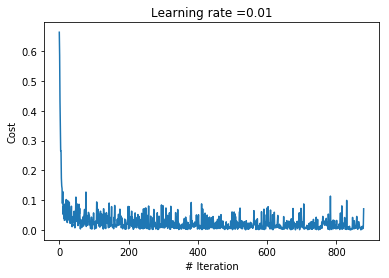

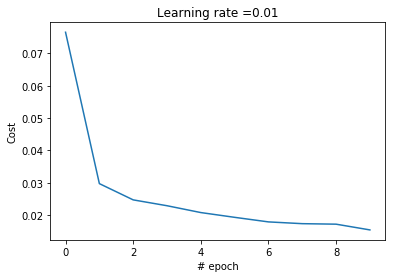

Accuracy of the model: 99.61%


In [40]:
# Check if the deep neural network is working
X, Y = load_dataset(first, second)
param = {"nb_layer":nb_layer, "neuron_quantity":neuron_quantity, "activations":activations, "X":X, "Y":Y, "epoch":10, "batch_size":128,\
         "optimization": "adam", "learning_rate":0.01, "momentum_beta":0.9, "rms_beta":0.999, "show_cost":True}
weight, bias, _, _ = improved_deep_neural_network(**param)

# Check if the prediction function works well
result = predict(X, weight, bias, nb_layer, activations)
accuracy = model_accuracy(result, Y)

# Tuning back the results from one-hot encoding to categorical values
# This will allow us to have a better comparison when comparing with the picture
Y = np.where(Y == 0, first, second)
result = np.where(result == 0, first, second)

print("Accuracy of the model: {0:.2f}%".format(accuracy*100))

Result was: [5]
Prediction was: [5]


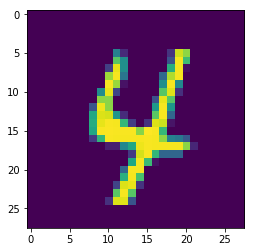

In [41]:
# Checking if the Neural Network learned properly with images
ind = 10000
print("Result was: {0}".format(Y[:, ind]))
print("Prediction was: {0}".format(result[:, ind]))
plt.imshow(A["0"][:, ind].reshape(28,28))

In [42]:
# Checking where we are wrong
list_error = [i for i, x in enumerate(Y.flatten() != result.flatten()) if x]
error_rate = len(list_error) / len(Y.flatten()) * 100
print("The model predicted wrong {0} times, or {1:.2f}% of the time".format(len(list_error), error_rate))

The model predicted wrong 44 times, or 0.39% of the time


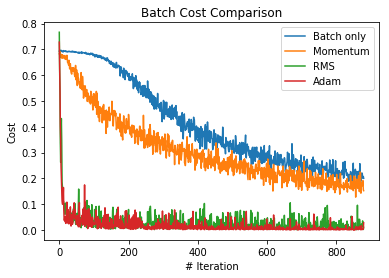

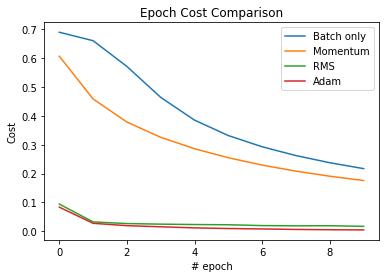

In [43]:
# Comparing models
X, Y = load_dataset(first, second)
param = {"nb_layer":nb_layer, "neuron_quantity":neuron_quantity, "activations":activations, "X":X, "Y":Y, "epoch":10, "batch_size":128,\
         "optimization": None, "learning_rate":0.01, "momentum_beta":0.9, "rms_beta":0.999, "show_cost":False}
weight, bias, no_batch, no_epoch = improved_deep_neural_network(**param)
no_result = predict(X, weight, bias, nb_layer, activations)
no_accuracy = round(model_accuracy(no_result, Y)*100, 2)

X, Y = load_dataset(first, second)
param = {"nb_layer":nb_layer, "neuron_quantity":neuron_quantity, "activations":activations, "X":X, "Y":Y, "epoch":10, "batch_size":128,\
         "optimization": "momentum", "learning_rate":0.01, "momentum_beta":0.9, "rms_beta":0.999, "show_cost":False}
weight, bias, mom_batch, mom_epoch = improved_deep_neural_network(**param)
mom_result = predict(X, weight, bias, nb_layer, activations)
mom_accuracy = round(model_accuracy(mom_result, Y)*100, 2)

X, Y = load_dataset(first, second)
param = {"nb_layer":nb_layer, "neuron_quantity":neuron_quantity, "activations":activations, "X":X, "Y":Y, "epoch":10, "batch_size":128,\
         "optimization": "rmsprop", "learning_rate":0.01, "momentum_beta":0.9, "rms_beta":0.999, "show_cost":False}
weight, bias, rms_batch, rms_epoch = improved_deep_neural_network(**param)
rms_result = predict(X, weight, bias, nb_layer, activations)
rms_accuracy = round(model_accuracy(rms_result, Y)*100, 2)

X, Y = load_dataset(first, second)
param = {"nb_layer":nb_layer, "neuron_quantity":neuron_quantity, "activations":activations, "X":X, "Y":Y, "epoch":10, "batch_size":128,\
         "optimization": "adam", "learning_rate":0.01, "momentum_beta":0.9, "rms_beta":0.999, "show_cost":False}
weight, bias, adam_batch, adam_epoch = improved_deep_neural_network(**param)
adam_result = predict(X, weight, bias, nb_layer, activations)
adam_accuracy = round(model_accuracy(adam_result, Y)*100, 2)

# Display the Cost/#Iteration plot
plt.plot(no_batch, label="Batch only")
plt.plot(mom_batch, label="Momentum")
plt.plot(rms_batch, label="RMS")
plt.plot(adam_batch, label="Adam")
plt.ylabel("Cost")
plt.xlabel("# Iteration")
plt.title("Batch Cost Comparison")
plt.legend()
plt.show()

# Display the Cost/#Epoch plot
plt.plot(no_epoch, label="Batch only")
plt.plot(mom_epoch, label="Momentum")
plt.plot(rms_epoch, label="RMS")
plt.plot(adam_epoch, label="Adam")
plt.ylabel("Cost")
plt.xlabel("# epoch")
plt.title("Epoch Cost Comparison")
plt.legend()
plt.show()

In [44]:
# Display accuracy
print("Batch only accuracy: {0}%, Momentum accuracy: {1}%".format(no_accuracy, mom_accuracy))
print("RMSProp accuracy: {0}%, Adam accuracy: {1}%".format(rms_accuracy, adam_accuracy))

Batch only accuracy: 97.95%, Momentum accuracy: 98.64%
RMSProp accuracy: 99.55%, Adam accuracy: 99.95%


To Do:  
Implement possibility for different weight initialization  
Different Cost function for different purposes  
Finish Regularization + Normalization  
Finish CNN  
Begin RNN  
Appendix